This script does four things to produce a normalized database of Rubisco kinetic parameters.
1. Filters all dubious data (manually annotated), data about mutants and data not measured at 25 C.
2. Assigns error ranges in cases where they are not reported based on the average coefficient of variation for that measurement.
3. Merges S with kinetic data from the same reference even though they were measured at different pH.
4. Infers values and 95% CIs for parameters that are not directly measured - vO, konC and konO. 
The resulting normalized file is written as a CSV. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import pearsonr

from stats_utils import combine_dists, RubiscoKinetics

In [2]:
na_values = ["", " ", "  ", "\t"]
full_df = pd.read_excel('../data/DatasetS1_RubiscoKinetics.xlsx', sheet_name='kinetic_data',
                        na_values=na_values)

kin_vars = 'KC, vC, S, KO, KRuBP, vO'.split(', ')
kin_var_SDs = ['%s_SD' % s for s in kin_vars]
kin_cols = kin_vars + kin_var_SDs

# all the above columns should be numeric
# set non-numeric values to NaN
for col in kin_cols:
    mask = ~full_df[col].map(np.isreal)
    full_df[mask] = np.NaN

Plotting reported measurement error against measured value shows general positive correlation for all measured variables with reported error -- this justifies 
* assumption that error scales multiplicatively
* use of log-scale regression since it is preferred for multiplicative error (see SI) 
* assumption (below) that error can be estimated for unreported cases using average multiplicative error

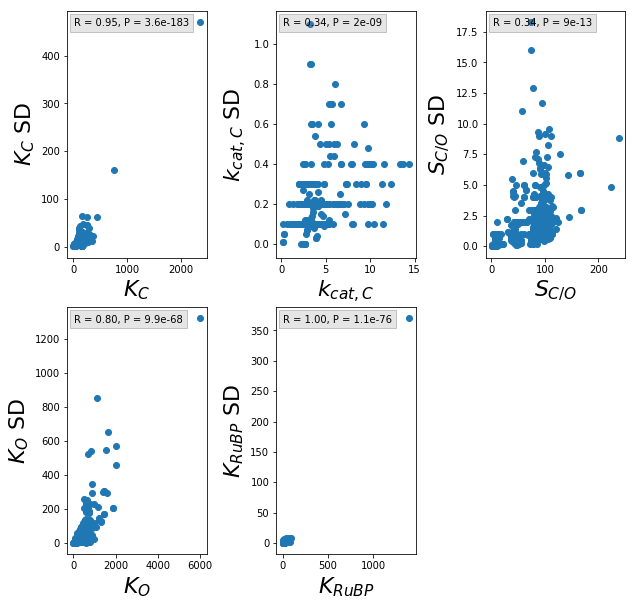

In [3]:
figure = plt.figure(figsize=(10,10))
nice_names = {'KC': '$K_C$', 
              'KO': '$K_O$', 
              'S': '$S_{C/O}$', 
              'vC': '$k_{cat,C}$', 
              'vO': '$k_{cat,O}$', 
              'KRuBP': '$K_{RuBP}$'}

for i, (v, v_sd) in enumerate(zip(kin_vars, kin_var_SDs)):
    if v == 'vO':
        continue
    
    ax = plt.subplot(2,3,i+1)
    
    mask = np.logical_and(full_df[v].notnull(), full_df[v_sd].notnull())
    masked_df = full_df[mask]
    rval, pval = pearsonr(masked_df[v], masked_df[v_sd])
    
    plt.scatter(full_df[v], full_df[v_sd])
    t = plt.text(0.05, 0.95, 'R = %.2f, P = %.2g' % (rval, pval),
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax.transAxes)
    t.set_bbox(dict(facecolor='grey', alpha=0.2))
    plt.xlabel(nice_names[v], fontsize=22)
    plt.ylabel(nice_names[v] + ' SD', fontsize=22)
    
plt.subplots_adjust(wspace=0.5)
plt.show()

Plotting the coefficient of variation (standard deviation over mean measurement) shows that it is roughly trendless, which also justifies use of log-scale regression and error estimation by CV.

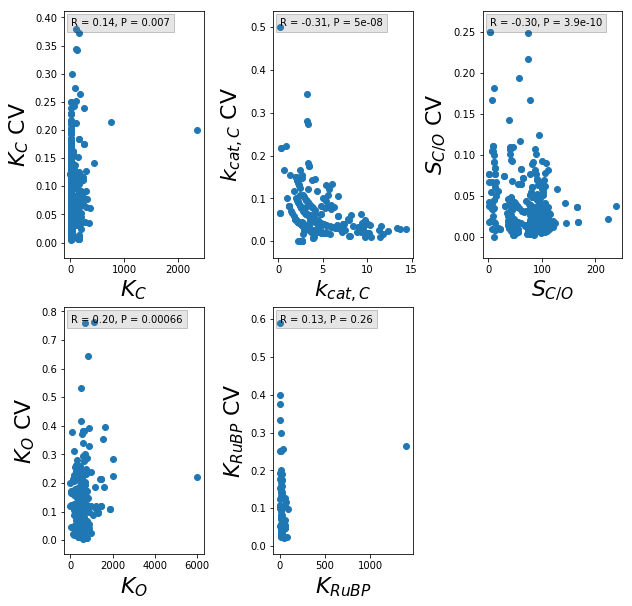

In [4]:
figure = plt.figure(figsize=(10,10))
nice_names = {'KC': '$K_C$', 
              'KO': '$K_O$', 
              'S': '$S_{C/O}$', 
              'vC': '$k_{cat,C}$', 
              'vO': '$k_{cat,O}$', 
              'KRuBP': '$K_{RuBP}$'}

for i, (v, v_sd) in enumerate(zip(kin_vars, kin_var_SDs)):
    if v == 'vO':
        continue
    
    ax = plt.subplot(2,3,i+1)
    mask = np.logical_and(full_df[v].notnull(), full_df[v_sd].notnull())
    masked_df = full_df[mask]
    
    cv = masked_df[v_sd] / masked_df[v]
    rval, pval = pearsonr(masked_df[v], cv)
    
    plt.scatter(masked_df[v], cv)
    t = plt.text(0.05, 0.95, 'R = %.2f, P = %.2g' % (rval, pval),
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax.transAxes)
    t.set_bbox(dict(facecolor='grey', alpha=0.2))
    
    plt.xlabel(nice_names[v], fontsize=22)
    plt.ylabel(nice_names[v] + ' CV', fontsize=22)
    
plt.subplots_adjust(wspace=0.5)
plt.show()

In [5]:
measured_vars = 'KC, vC, S, KO, KRuBP'.split(', ')
measured_var_SDs = ['%s_SD' % s for s in measured_vars]

relative_err = {}
for v, v_sd in zip(measured_vars, measured_var_SDs):
    mask = np.isfinite(full_df[v]) & np.isfinite(full_df[v_sd])
    masked_df = full_df[mask]
    
    cvs = masked_df[v_sd] / masked_df[v]
    relative_err[v] = np.nanmean(cvs)
    
print('Average Coefficients of Variation (CV)')
relative_err

Average Coefficients of Variation (CV)


{'KC': 0.09126866749446716,
 'vC': 0.05944949215524039,
 'S': 0.03441010232654772,
 'KO': 0.13201904177886598,
 'KRuBP': 0.12110092265200154}

In [6]:
# In places where we don't have error estimates for important values, we assume
# 1) Error is proportional to measurement size.
# 2) Unreported standard deviations are like the mean %age for that value.
# In general it does appear that larger values have higher error in this data set.
# It also appears that the error is not normally distributed (fat tail) so I use 
# the mean percentage error instead of the median since we are being pessimistic. 
#
# KC mean, median error: 8.91%, 7.02% 0.07028021694214875
# vC mean, median error: 5.87%, 4.17%
# KO mean, median error: 13.00%, 10.98%
# S mean, median error: 3.21%, 2.16%
# KRuBP mean, median error: 9.63%, 7.70%
#
# Moreover, vO is almost always determined from S, vC, KO and KC. 
# We therefore assume that in all cases vO is not measured directly and so the 
# error in vO will be determined by bootstrapping from the errors in the other variables.
# 

var2err = relative_err
normed_df = full_df.copy()

for col, err_ratio in var2err.items():
    err_col = col + '_SD'
    
    mask = normed_df[col].notnull() & normed_df[err_col].isnull()
    masked = normed_df[mask]
    inferred_errors = masked[col] * err_ratio
    normed_df.loc[inferred_errors.index, err_col] = inferred_errors.values.astype(float)

In [7]:
# Check that everything has a reported error when there is a reported value now. 
# Should print all 0s below.
for col, err_ratio in var2err.items():
    err_col = col + '_SD'
    
    mask = normed_df[col].notnull() & normed_df[err_col].isnull()
    print(col, mask.sum())

KC 0
vC 0
S 0
KO 0
KRuBP 0


In [8]:
# Jordan 1984 data has several specificity values for R. rubrum and Spinach RuBisCOs.
# Combining them here into one row by bootstrapping.

jordan84 = normed_df[normed_df.short_ref == 'Jordan 1984'].copy()
jordan84.head()

,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,isoform,variant,LSU_uniprot,taxonomy,note,short_ref,year,primary_ref,pmid_or_doi,citation
196,Rhodospirillum rubrum,rubrum_table3exp3_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,12.0,...,2,NaN,NaN,Alphaproteobacteria,Table 3,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398735,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
197,Rhodospirillum rubrum,rubrum_table3exp2_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,10.0,...,2,NaN,NaN,Alphaproteobacteria,Table 3,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398734,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
198,Rhodospirillum rubrum,rubrum_table1exp2b_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,11.4,...,2,NaN,NaN,Alphaproteobacteria,Table 1,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398733,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
199,Rhodospirillum rubrum,rubrum_table1exp2a_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,11.1,...,2,NaN,NaN,Alphaproteobacteria,Table 1,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398732,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
200,Rhodospirillum rubrum,rubrum_table1exp1b_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,11.8,...,2,NaN,NaN,Alphaproteobacteria,Table 1,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398731,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."


In [9]:
# Jordan 1984 data has several specificity values for R. rubrum and Spinach RuBisCOs.
# Combining them here into one row by bootstrapping.

merged_df = normed_df.copy()

# Grab rows for Jordan 84 R. rubrum
mask = (merged_df.short_ref == 'Jordan 1984') & (merged_df.species == 'Rhodospirillum rubrum')
rubrum_rows = merged_df[mask].copy()
rubrum_rows = rubrum_rows[rubrum_rows.S.notnull()]  # Only take ones with S values

# Make a single row for this guy.
S, S_SD = combine_dists(rubrum_rows.S, rubrum_rows.S_SD, n=10000)
rubrum_row = rubrum_rows.iloc[0].copy()
rubrum_row.identifier = 'rubrum_S_jordan84'
rubrum_row.S = S
rubrum_row.S_SD = S_SD
merged_df.drop(rubrum_rows.index, axis=0, inplace=True)
merged_df = merged_df.append(rubrum_row)

# Grab rows for Jordan 84 S. oleracea
mask = (merged_df.short_ref == 'Jordan 1984') & (merged_df.species == 'Spinacia oleracea')
spinach_rows = merged_df[mask].copy()
spinach_rows = spinach_rows[spinach_rows.S.notnull()]  # Only take ones with S values

# Make a single row for this guy.
S, S_SD = combine_dists(spinach_rows.S, spinach_rows.S_SD, n=10000)
spinach_row = spinach_rows.iloc[0].copy()
spinach_row.identifier = 'oleracea_S_jordan84'
spinach_row.S = S
spinach_row.S_SD = S_SD
merged_df.drop(spinach_rows.index, axis=0, inplace=True)
merged_df = merged_df.append(spinach_row)

merged_df[merged_df.short_ref == 'Jordan 1984']

,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,isoform,variant,LSU_uniprot,taxonomy,note,short_ref,year,primary_ref,pmid_or_doi,citation
202,Amaranthus hybridus,hybridus_table3exp1_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,78.000000,...,1,B,NaN,C4 plants,Table 3,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398729,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
207,Spinacia oleracea,oleracea_table2_jordan84,1.0,0.0,False,11.0,1.003955,NaN,NaN,NaN,...,1,B,NaN,C3 plants,Table 2,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398724,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
196,Rhodospirillum rubrum,rubrum_S_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,11.247971,...,2,NaN,NaN,Alphaproteobacteria,Table 3,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398735,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."
203,Spinacia oleracea,oleracea_S_jordan84,1.0,0.0,False,NaN,NaN,NaN,NaN,83.386296,...,1,B,NaN,C3 plants,Table 3,Jordan 1984,1984,NaN,https://doi.org/10.1007/BF00398728,"Jordan DB, Ogren WL. 1984. The CO2/O2 specific..."


In [10]:
# Greene 2007 reports PCC 6301 using two measurement methods. Combining the S values 
# with their respective kinetic measurements even though they were measured at different pH.
# 
# Why? There is evidence that S is pH independent. This is good because many papers measure S at 
# pH 8.2-8.3 but vC, KC and KO at pH 8. We assume that these values can be merged.
# 

def first_val(axis):
    """Returns the first value in the axis or NaN if none."""
    mask = axis.notnull()
    if mask.sum() == 0:
        return np.NaN
    return axis[mask].values[0]

mask = (merged_df.identifier == '6301_green_a')
group_a_rows = merged_df[mask].copy()
pcc6301_row_a = group_a_rows.aggregate(first_val)

merged_df.drop(group_a_rows.index, axis=0, inplace=True)
merged_df = merged_df.append(pcc6301_row_a, ignore_index=True)

mask = (merged_df.identifier == '6301_green_b')
group_b_rows = merged_df[mask].copy()
pcc6301_row_b = group_b_rows.aggregate(first_val)

merged_df.drop(group_b_rows.index, axis=0, inplace=True)
merged_df = merged_df.append(pcc6301_row_b, ignore_index=True)

mask = (merged_df.short_ref == 'Greene 2007')
merged_df[mask]

,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,isoform,variant,LSU_uniprot,taxonomy,note,short_ref,year,primary_ref,pmid_or_doi,citation
616,Synechococcus 6301,6301_green_a,1.0,0.0,E. coli,273.0,10.000000,11.4,0.100000,43.9,...,1,B,NaN,Cyanobacteria,"S measured at pH 8.3, rest at 8",Greene 2007,2007,NaN,17391103,"Greene, D. N., Whitney, S. M., and Matsumura, ..."
617,Synechococcus 6301,6301_green_b,0.0,0.0,E. coli,284.0,25.920302,11.6,0.689614,43.0,...,1,B,NaN,Cyanobacteria,"second row of table, S measured in Morell et a...",Greene 2007,2007,NaN,17391103,"Greene, D. N., Whitney, S. M., and Matsumura, ..."


In [11]:
# In the remaining cases, there are two rows at different pH values but
# the only difference is that one row has S values and the other row has the rest.
# 
# Here we merge those doublet rows. 
# Note: von Caemmerer 1994 have multiple measurements of the same RuBisCO using different methods.
# Badger 1977 uses different pH values to measure oxygenation and carboxylation params.
# These special cases are not merged yet. 

grouped_species_ref = merged_df.groupby(['species', 'short_ref'])
numeric_cols = ['KC', 'KC_SD', 'KO', 'KO_SD', 'vC', 'vC_SD', 
                'vO', 'vO_SD', 'S', 'S_SD', 'KRuBP', 'KRuBP_SD']

print('Starting with', merged_df.shape[0], 'rows')
pairs = 0
for name, group in grouped_species_ref:
    n = group.shape[0]
    
    if n == 2:
        species, short_ref = name
        mask = (merged_df.species == species) & (merged_df.short_ref == short_ref)
        appropriate_rows = merged_df[mask]
        sample_row = appropriate_rows.iloc[0]
        
        # This row logic checks that we don't have 2 values for any one parameter
        numeric_vals = appropriate_rows[numeric_cols]
        if (numeric_vals.notnull().sum() > 1).any():
            print('Skipping', sample_row.short_ref, sample_row.species)
            continue
            
        # Can proceed with the merge        
        print('Merging', sample_row.short_ref, sample_row.species)
        pairs += 1
        single_row = appropriate_rows.agg(first_val)        
        merged_df.drop(appropriate_rows.index, axis=0, inplace=True)
        merged_df = merged_df.append(single_row, ignore_index=True)

print('Merged', pairs, 'pairs of rows')
print('Ending with', merged_df.shape[0], 'rows')

Starting with 618 rows
Merging Orr 2016 Agriophyllum squarrosum
Merging Orr 2016 Agrostis scabra
Merging Orr 2016 Agrostis stolonifera
Merging Orr 2016 Amphicarpaea bracteata
Merging Orr 2016 Arctagrostis latifolia
Merging Orr 2016 Artemisia myriantha
Merging Orr 2016 Artemisia vulgaris L.
Skipping Badger 1977 Atriplex glabriuscula
Merging Hermida-Carrera 2016 Avena sativa
Merging Hermida-Carrera 2016 Beta vulgaris
Merging Orr 2016 Beta vulgarisssp.vulgaris
Merging Hermida-Carrera 2016 Brassica oleracea
Merging Orr 2016 Bromus anomalus
Merging Orr 2016 Calamagrostis arundinacea
Merging Orr 2016 Calamagrostis canescens
Merging Orr 2016 Calamagrostis foliosa
Merging Orr 2016 Calamagrostis inexpansa
Merging Orr 2016 Calamagrostis nutkaensis
Merging Hermida-Carrera 2016 Capsicum annuum
Merging Orr 2016 Chenopodium murale
Merging Orr 2016 Chenopodium petiolare
Merging Orr 2016 Chenopodium rubrum
Merging Orr 2016 Chrysanthellum indicum var. afroamericanum
Merging Orr 2016 Citrullus ecirrhosu

In [12]:
# Dropping columns that are just gonna get in the way downstream. 
# Note: we are keeping the pH column even though it is no longer strictly accurate due to merging above.
cols_to_drop = ['d13C_permil', 'd13c_SD', 'ci_source', 'pKa', 'primary_ref']
merged_df.drop(cols_to_drop, axis=1, inplace=True)

In [13]:
# Calculate the vO and SD thereof where applicable. 
cols_of_interest = ['S', 'KC', 'KO', 'vC']
carbo_cols = ['KC', 'vC']

merged_df['vO_reported'] = merged_df.vO
merged_df['vO_SD_reported'] = merged_df.vO_SD

merged_df['vO'] = np.NaN
merged_df['vO_95CI_low'] = np.NaN
merged_df['vO_95CI_high'] = np.NaN
merged_df['kon_C'] = np.NaN
merged_df['kon_C_95CI_low'] = np.NaN
merged_df['kon_C_95CI_high'] = np.NaN
merged_df['kon_O'] = np.NaN
merged_df['kon_O_95CI_low'] = np.NaN
merged_df['kon_O_95CI_high'] = np.NaN

for idx in merged_df.index:
    row = merged_df.loc[idx]
    rubkin = RubiscoKinetics.from_kv(row)
    rubkin.infer(n=10000)
    
    merged_df.set_value(idx, 'kon_C', rubkin.kon_C)
    if rubkin.kon_C_95CI is not None:
        merged_df.set_value(idx, 'kon_C_95CI_low', rubkin.kon_C_95CI[0])
        merged_df.set_value(idx, 'kon_C_95CI_high', rubkin.kon_C_95CI[1])

    merged_df.set_value(idx, 'vO', rubkin.vO)
    if rubkin.vO_95CI is not None:
        merged_df.set_value(idx, 'vO_95CI_low', rubkin.vO_95CI[0])
        merged_df.set_value(idx, 'vO_95CI_high', rubkin.vO_95CI[1])

    merged_df.set_value(idx, 'kon_O', rubkin.kon_O)
    if rubkin.kon_O_95CI is not None:
        merged_df.set_value(idx, 'kon_O_95CI_low', rubkin.kon_O_95CI[0])
        merged_df.set_value(idx, 'kon_O_95CI_high', rubkin.kon_O_95CI[1])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_l

In [14]:
desired_col_order = ['species', 'identifier', 'primary', 'mutant', 'heterologous_expression',
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO_95CI_low', 'vO_95CI_high',
       'vO_reported', 'vO_SD_reported', 'kon_C', 'kon_C_95CI_low', 'kon_C_95CI_high', 'kon_O',
       'kon_O_95CI_low', 'kon_O_95CI_high', 'KRuBP', 'KRuBP_SD', 'temp_C', 'pH', 'isoform', 'variant', 
       'taxonomy', 'use', 'note', 'short_ref', 'pmid_or_doi', 'citation']
measurement_cols = [
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO_95CI_low', 'vO_95CI_high',
       'vO_reported', 'vO_SD_reported', 'kon_C', 'kon_C_95CI_low', 'kon_C_95CI_high', 'kon_O',
       'kon_O_95CI_low', 'kon_O_95CI_high', 'KRuBP', 'KRuBP_SD']
merged_df[measurement_cols].infer_objects() # convert to floats.
merged_df[desired_col_order].to_csv('../data/DatasetS4_RubiscoKineticsFull_Merged.csv',
                                    float_format='%.3g')

In [15]:
print(merged_df.shape[0], 'rows')
print(merged_df.species.unique().size, 'unique species in merged dataset')

521 rows
384 unique species in merged dataset


In [16]:
# Categorically - not using mutants or ones where "use" is set to false. Only using data at 25 C.
# We set "use" to false for meta-analyses that overlap with Savir et al., e.g. Badger 1998.
mask = (merged_df.use == 1.0) & (merged_df.mutant != 1.0) & (merged_df.temp_C == 25)
filtered_merged_df = merged_df[mask].copy()

print(filtered_merged_df.shape[0], 'rows')
filtered_merged_df.head(2)

397 rows


,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,vO_reported,vO_SD_reported,vO_95CI_low,vO_95CI_high,kon_C,kon_C_95CI_low,kon_C_95CI_high,kon_O,kon_O_95CI_low,kon_O_95CI_high
0,Methanococcoides burtonii,burtonii_coli_alonso,1.0,0.0,E. coli,130.0,4.0,2.0,0.1,1.18,...,0.03,NaN,0.024049,0.042272,0.015392,0.013649,0.017241,0.013036,0.0113,0.01506
1,Methanococcoides burtonii L2,burtonii_L2_coli_alonso,1.0,0.0,E. coli,NaN,NaN,1.9,0.1,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
desired_col_order = ['species', 'identifier', 'primary', 'mutant', 'heterologous_expression',
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO_95CI_low', 'vO_95CI_high',
       'vO_reported', 'vO_SD_reported', 'kon_C', 'kon_C_95CI_low', 'kon_C_95CI_high', 'kon_O',
       'kon_O_95CI_low', 'kon_O_95CI_high', 'KRuBP', 'KRuBP_SD', 'temp_C', 'pH', 'isoform', 'variant',
       'taxonomy', 'note', 'short_ref', 'pmid_or_doi', 'citation']
measurement_cols = [
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO_95CI_low', 'vO_95CI_high',
       'vO_reported', 'vO_SD_reported', 'kon_C', 'kon_C_95CI_low', 'kon_C_95CI_high', 'kon_O',
       'kon_O_95CI_low', 'kon_O_95CI_high', 'KRuBP', 'KRuBP_SD']
filtered_merged_df[measurement_cols].infer_objects() # convert to floats.
filtered_merged_df[desired_col_order].to_csv('../data/DatasetS2_RubiscoKinetics_Merged.csv',
                                             float_format='%.3g')

In [18]:
# Output a CSV of the full dataset with just the columns I am outputting for the others.
desired_col_order = ['species', 'identifier', 'primary', 'mutant', 'heterologous_expression',
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO_SD',
       'KRuBP', 'KRuBP_SD', 'temp_C', 'pH', 'isoform', 'variant',
       'taxonomy', 'note', 'short_ref', 'pmid_or_doi', 'citation']
measurement_cols = [
       'KC', 'KC_SD', 'vC', 'vC_SD', 'S', 'S_SD', 'KO', 'KO_SD', 'vO', 'vO', 'vO', 'KRuBP', 'KRuBP_SD']
full_df[measurement_cols].infer_objects() # convert to floats.
full_df[desired_col_order].to_csv('../data/DatasetS1_SourceRubiscoKinetics.csv', float_format='%.3g')